In [1]:
import os

import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import seaborn as sns

import pcms.haar
import pcms.tree
import utils

In [21]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

## Part 1: Verify functionality of CDF estimator

#### Evaluate at a single point

In [3]:
n_leaves = 100
func = np.random.dirichlet(alpha=np.ones((n_leaves,), dtype=float))
y = 112

In [4]:
cdf_val = pcms.haar.cdf_rand_basis(y, func, eps=0.01, delta=0.01)

In [5]:
print(cdf_val)

0.9024505160553037


#### Evaluate at multiple points

In [6]:
quant50 = root_scalar(lambda x: pcms.haar.cdf_rand_basis(x, func, eps=0.01, delta=0.01) - 0.5, bracket=(0,150), method='bisect', xtol=1e-8)
quant80 = root_scalar(lambda x: pcms.haar.cdf_rand_basis(x, func, eps=0.01, delta=0.01) - 0.8, bracket=(0,150), method='bisect', xtol=1e-8)
quant90 = root_scalar(lambda x: pcms.haar.cdf_rand_basis(x, func, eps=0.01, delta=0.01) - 0.9, bracket=(0,150), method='bisect', xtol=1e-8)
quant95 = root_scalar(lambda x: pcms.haar.cdf_rand_basis(x, func, eps=0.01, delta=0.01) - 0.95, bracket=(0,150), method='bisect', xtol=1e-8)

In [7]:
print(quant50.root, quant80.root, quant90.root, quant95.root)

9.71706060518045 52.531079316395335 83.5606182605261 136.24877921829466


In [8]:
n_points = 1000
ys = np.linspace(0.1, 140, n_points)

In [9]:
cdf_vals = pcms.haar.cdf_rand_basis(ys, func, eps=0.01, delta=0.01)

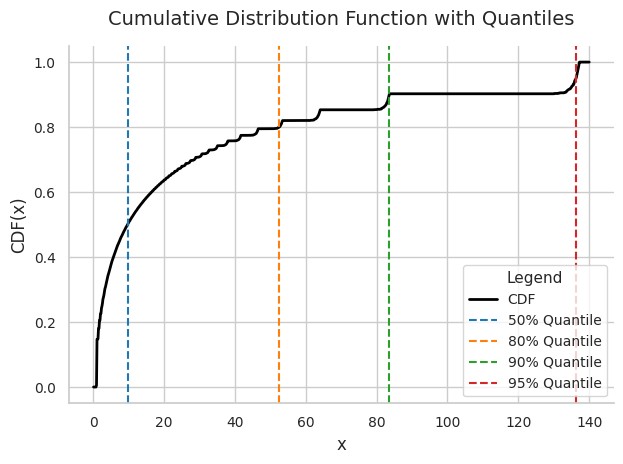

In [10]:
sns.set_theme(style="whitegrid")

# Create high-DPI figure for sharpness
fig, ax = plt.subplots()

# Plot CDF
ax.plot(ys, cdf_vals, label='CDF', color='black', linewidth=2)

# Vertical quantile lines
ax.axvline(quant50.root, linestyle='--', color='#1f77b4', label='50% Quantile')
ax.axvline(quant80.root, linestyle='--', color='#ff7f0e', label='80% Quantile')
ax.axvline(quant90.root, linestyle='--', color='#2ca02c', label='90% Quantile')
ax.axvline(quant95.root, linestyle='--', color='#d62728', label='95% Quantile')

# Labels and title
ax.set_xlabel("x", fontsize=12)
ax.set_ylabel("CDF(x)", fontsize=12)
ax.set_title("Cumulative Distribution Function with Quantiles", fontsize=14, pad=15)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()

ax.legend(title="Legend", fontsize=10, title_fontsize=11, loc="lower right", frameon=True)

plt.tight_layout()
plt.show()

#### Numerically differentiate to obtain PDF

In [11]:
pdf_vals = np.gradient(cdf_vals, ys)

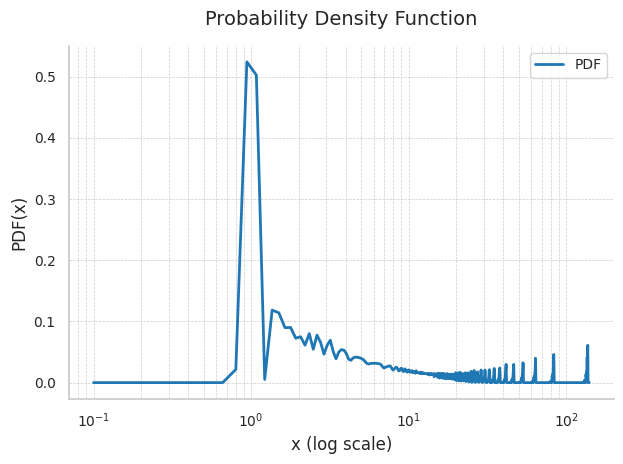

In [12]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots()
ax.plot(ys, pdf_vals, color='#1f77b4', linewidth=2, label='PDF')
ax.set_xscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

ax.set_xlabel("x (log scale)", fontsize=12)
ax.set_ylabel("PDF(x)", fontsize=12)
ax.set_title("Probability Density Function", fontsize=14, pad=15)

ax.tick_params(axis='both', which='major', labelsize=10)
sns.despine()
ax.legend(fontsize=10, loc="best")

plt.tight_layout()
plt.show()

## Part 2: Level of significance of pcms.haar-like coordiantes of Guerrero Negro microbial mat dataset against 97% Greengenes tree

#### Load 97% Greengenes tree

In [26]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'))

In [30]:
otu_map_filepath = os.path.join(GG_OTU_MAPS, '97_otu_map.txt')
seq_id2otu, otu2repr_seq_id = utils.load_gg_seq_id2otu_id_maps(otu_map_filepath)

In [31]:
seq_id2leaf_idx = utils.build_gg_seq_id2leaf_idx_map(tree)

#### Load Guerrero Negro dataset

In [32]:
gn_data_filepath = os.path.join(GN_DATA, 'otus.txt')
gn_metadata_filepath = os.path.join(GN_DATA, 'metadata.txt')
gn_data, gn_metadata = utils.load_gn_seq_id_abundances(gn_data_filepath, gn_metadata_filepath)

#### Compute Haar-like coordinates